In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from skimage.transform import resize
import time

### Load and plot data example

In [12]:
ds = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/GOES16-ABI/GOES16_C13_1024N_6140E_EUREC4A.zarr")
ds

<xarray.Dataset>
Dimensions:  (time: 2871, lat: 2310, lon: 1540)
Coordinates:
  * lat      (lat) float64 24.0 23.99 23.98 23.98 ... 10.02 10.02 10.01 10.0
  * lon      (lon) float64 -60.99 -60.98 -60.97 -60.95 ... -40.03 -40.02 -40.01
  * time     (time) datetime64[ns] 2020-01-01T00:00:21.600000 ... 2020-02-29T...
Data variables:
    C13      (time, lat, lon) float64 dask.array<chunksize=(1, 2310, 1540), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.7
    converted_by:    Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_with:    download_GOES16.py with its last modification on Mon Feb...
    creation_date:   Tue Mar  9 19:37:21 2021
    description:     GOES16 satellite data regridded on a regular grid
    institution:     Max Planck Institute for Meteorology, Hamburg, Germany
    python_version:  3.7.6 | packaged by conda-forge | (default, Mar  5 2020,...
    source:          gcp-public-data-goes-16/ABI-L1b-RadF/2020/001/00/OR_ABI-...
    title:           Geostationary satellite imagery from GOES16 on regular grid
    version:         --

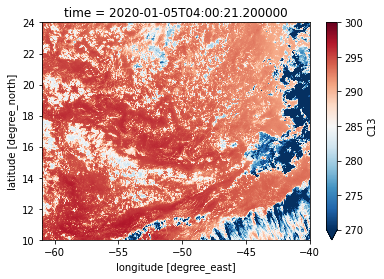

In [13]:
# Using Hauke's colour schemes
vmin = 270
vmax = 300
cmap = "RdBu_r"

test_scene = ds.C13.isel(time=200)
test_scene.plot(cmap=cmap, vmin=vmin, vmax=vmax)

### Define area subset and cloud mask following [Schulz et al. (2022)](https://doi.org/10.5194/essd-14-1233-2022).
- Longitude $\in$ [58-48] W, latitude $\in$ [10-20] N.
- Recast to equidistant grid, since ``cloudmetrics`` assumes ``dx=dy=constant``
- Cloudy pixels are C13 $\in$ [280-290] K
- Reject if 25<sup>th</sup> percentile of C13 < 285 (high clouds)

(1650, 734)


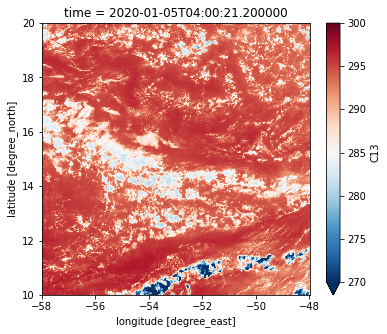

In [26]:
# Subset original image
lat0, lat1, lon0, lon1 = [10, 20, -58, -47.99] # Bodge to make latitude even number of points
T_high_min = 285

test_sub = test_scene.sel(lat=slice(lat1, lat0), lon=slice(lon0,lon1))
plt.figure(figsize=(6,5))
test_sub.plot(cmap=cmap, vmin=vmin, vmax=vmax)

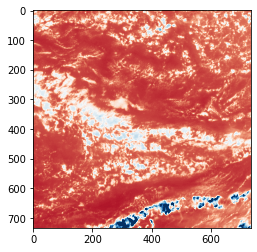

In [27]:
# Resize to square where dlat=dlon (with anti-aliasing). Don't know if this is wildly inappropriate.
imin = np.argmin(test_sub.shape)
test_sub_res = resize(test_sub, (test_sub.shape[imin],test_sub.shape[imin]), anti_aliasing=True)
plt.imshow(test_sub_res, cmap=cmap, vmin=vmin, vmax=vmax)

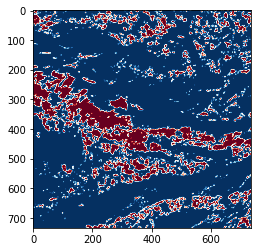

In [28]:
# Cloud mask
T_cl_min = 280
T_cl_max = 290

test_cm = np.zeros(test_sub_res.shape,dtype=int)
test_cm[(test_sub_res < T_cl_max) & (test_sub_res > T_cl_min)] = 1
plt.imshow(test_cm, cmap=cmap)

In [29]:
# Test high clouds
q_cutoff = 25
T_cutoff = 285

# Can use either brightness temperature of cloudy pixels, or all pixels.
# Reading from his manuscript, it seems Hauke uses the latter.
# T_q = np.percentile(test_sub_res[test_cm == 1], q_cutoff)
T_q = np.percentile(test_sub_res, q_cutoff)

print('25th percentile T:', T_q)
if T_q < T_cutoff:
    print('Reject due to high clouds')

25th percentile T: 291.334452228821


### Test a few metrics

In [30]:
import cloudmetrics

# Cloud mask metrics
print('cf   : ',cloudmetrics.mask.cloud_fraction(test_cm))
print('frac : ',cloudmetrics.mask.fractal_dimension(test_cm))
# print('open sky:', cloudmetrics.mask.open_sky(test_cm))

# Object metrics
# Could do this using cloud mask directly...
# print('iorg : ',cloudmetrics.mask.iorg_objects(test_cm, periodic_domain=False))
# print('scai : ',cloudmetrics.mask.scai_objects(test_cm, periodic_domain=False))
# print('cop  : ',cloudmetrics.mask.cop_objects(test_cm, periodic_domain=False))

# ...or using object labels explicitly (would need to make the mask periodic first yourself if periodic bcs)
object_labels = cloudmetrics.objects.label(test_cm)
print('iorg : ',cloudmetrics.objects.iorg(object_labels))
print('scai : ',cloudmetrics.objects.scai(object_labels))
print('cop  : ',cloudmetrics.objects.cop(object_labels))
print('max len  : ',cloudmetrics.objects.max_length_scale(object_labels))
print('mean len  : ',cloudmetrics.objects.mean_length_scale(object_labels))
print('mean ecc  : ',cloudmetrics.objects.mean_eccentricity(object_labels))
print('mean peri  : ',cloudmetrics.objects.mean_perimeter_length(object_labels))

# Scalar metrics
print('spectral : ',cloudmetrics.scalar.compute_all_spectral(test_sub_res))
print('woi1 :',cloudmetrics.scalar.woi1(test_sub_res))
print('woi2 :',cloudmetrics.scalar.woi2(test_sub_res))
print('woi3 :',cloudmetrics.scalar.woi3(test_sub_res))
print('mean :',cloudmetrics.scalar.mean(test_sub_res))
print('var :',cloudmetrics.scalar.var(test_sub_res))
# print('skew :',cloudmetrics.scalar.skew(test_sub_res)) # FIXME need to tell scipy.stats.skew to go None, not along 0 azis
# print('kurt :',cloudmetrics.scalar.kurtosis(test_sub_res)) # FIXME need to tell scipy.stats.skew to go None, not along 0 azis

# Alternative (explicit) computation of spectral metrics
# wavenumbers, psd_1d_radial, psd_1d_azimuthal = cloudmetrics.scalar.compute_spectra(test_sub_res)
# print('spec. len. mom. :', cloudmetrics.scalar.spectral_length_moment(wavenumbers, psd_1d_radial))


cf   :  0.184280082263585
frac :  1.6511023768766708
iorg :  0.6181480612976324
scai :  1.7762731753536443
cop  :  0.01866468867679452
max len  :  196.95684806576287
mean len  :  8.445310880131588
mean ecc  :  0.8945377009027107
mean peri  :  25.986049703388755
spectral :  (0.8994960581634415, -0.7778260403850719, -1.0188161275991174, 122.33333333333331, 30.013483353727796)
woi1 : 0.4695693814023009
woi2 : 1.1538600729421894e-05
woi3 : 0.37586488140963287
mean : 292.50199411221325
var : 18.0375944717884


## Compute and store `cloudmetrics` for all scenes

In [32]:
import inspect

metrics = ['cloud_fraction',
           'fractal_dimension',
           'open_sky',
           'cop',
           'iorg',
           'scai',
           'max_length_scale',
           'mean_eccentricity',
           'mean_length_scale',
           'mean_perimeter_length',
           'num_objects',
           'orientation',
           'spectral_length_moment',
           'spectral_anisotropy',
           'spectral_slope',
           'woi1',
           'woi2',
           'woi3'
          ]

# These are the metrics to choose from
available_mask_metrics = dict(inspect.getmembers(cloudmetrics.mask, inspect.isfunction))
available_object_metrics = dict(inspect.getmembers(cloudmetrics.objects, inspect.isfunction))
available_scalar_metrics = dict(inspect.getmembers(cloudmetrics.scalar, inspect.isfunction))

df_metrics = pd.DataFrame(index=ds['time'], columns=metrics)

### Main loop, using variable definitions from earlier cells

Processing  2020-01-12T18:00:20.400000000 scene  559 / 2871


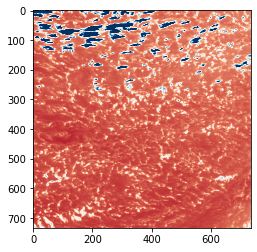

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  2020-01-12T18:30:20.400000000 scene  560 / 2871


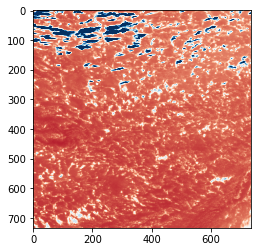

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  2020-01-12T19:00:20.300000000 scene  561 / 2871


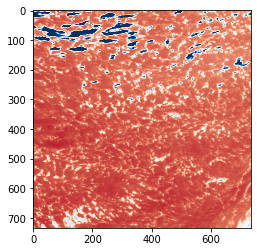

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  2020-01-12T19:30:20.300000000 scene  562 / 2871


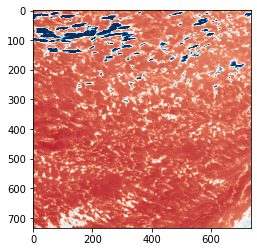

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  2020-01-12T20:00:20.300000000 scene  563 / 2871


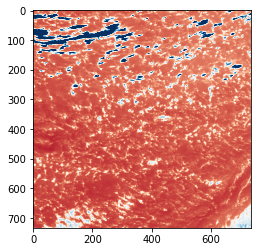

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  2020-01-12T20:30:20.300000000 scene  564 / 2871


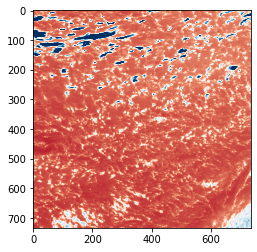

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  2020-01-12T21:00:20.200000000 scene  565 / 2871


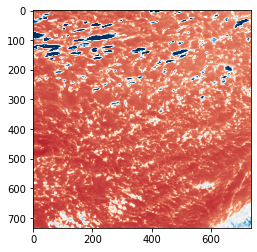

Computing cloud_fraction
Computing fractal_dimension
Computing open_sky


KeyboardInterrupt: 

In [43]:
for i in range(558,len(ds['time'])):
    print('Processing ', ds['time'][i].data, 'scene ', i+1, '/', len(ds['time']))
    
    # These operations will try to actually access the data, but network access to data source 
    # is unstable so need to build in fail-safe
    while True:
        # Select
        scene = ds.C13.isel(time=i)

        # Subset
        scene = scene.sel(lat=slice(lat1, lat0), lon=slice(lon0,lon1))

        try:
            # Resize
            imin = np.argmin(scene.shape)
            scene = resize(scene, (scene.shape[imin],scene.shape[imin]), anti_aliasing=True)
            assert(np.isnan(scene).any() == False)
        except:
            print('Unable to access scene, retrying...')
            time.sleep(5)
            continue
        break
    
    # Plot scene
    plt.imshow(scene, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.show()
    
    # Define cloud mask
    cloud_mask = np.zeros(scene.shape,dtype=int)
    cloud_mask[(scene < T_cl_max) & (scene > T_cl_min)] = 1
    
    # Test high clouds
    if np.percentile(test_sub_res, q_cutoff) < T_cutoff:
        print('Reject due to high clouds')
        continue
    
    # Compute selected metrics
    computed_object_labels = False
    computed_spectra = False
    for j in range(len(metrics)):
        
        # Cloud object metrics
        if metrics[j] in available_object_metrics.keys():
            print('Computing', metrics[j])
            
            # Compute object labels if not done yet
            if not computed_object_labels:
                object_labels = cloudmetrics.objects.label(cloud_mask)
                computed_object_labels = True
            
            # Compute metric
            fn_metric = available_object_metrics[metrics[j]]
            df_metrics.iloc[i].loc[metrics[j]] = fn_metric(object_labels)
        
        # Cloud mask metrics
        elif metrics[j] in available_mask_metrics.keys():
            print('Computing', metrics[j])
            fn_metric = available_mask_metrics[metrics[j]]
            
            # Open sky exception - just take the mean open sky area (second function output)
            if 'open_sky' in metrics[j]:
                _, df_metrics.iloc[i].loc[metrics[j]] = fn_metric(cloud_mask)
            else:
                df_metrics.iloc[i].loc[metrics[j]] = fn_metric(cloud_mask)

        # Cloud scalar metrics
        elif metrics[j] in available_scalar_metrics.keys():
            print('Computing', metrics[j])
            fn_metric = available_scalar_metrics[metrics[j]]
            
            # Spectral metrics exception
            if 'spectral' in metrics[j]:
                
                # Compute spectra if not done yet
                if not computed_spectra:
                    wavenumbers, psd_1d_radial, psd_1d_azimuthal = cloudmetrics.scalar.compute_spectra(scene)
                    computed_spectra = True
                
                # Compute metrics
                if 'anisotropy' in metrics[j]:
                    df_metrics.iloc[i].loc[metrics[j]] = fn_metric(psd_1d_azimuthal)
                else:
                    df_metrics.iloc[i].loc[metrics[j]] = fn_metric(wavenumbers, psd_1d_radial)
            
            # All other scalar metrics computed normally
            else:
                df_metrics.iloc[i].loc[metrics[j]] = fn_metric(scene)
        
        # Store after each scene
        df_metrics.to_hdf('df_metrics.h5', 'cloudmetrics', mode='w')
df_metrics

## Load, filter, standardise, compute pca

In [65]:
from Postprocess import analysis, utils
from sklearn.decomposition import PCA

# Read from file
df_metrics_pp = pd.read_hdf('df_metrics.h5')

# Filter scenes which miss metrics
nan_filter = metrics
for ind in nan_filter:
    df_metrics_pp = df_metrics_pp[df_metrics_pp[ind].notna()]
# print(df_metrics_pp.isna().any())

# Standardise metrics
data = df_metrics_pp.to_numpy()
data = utils.stand(data)
    
# Compute PCA
pca = PCA()
x_pca = pca.fit_transform(data)

cloud_fraction            False
fractal_dimension         False
open_sky                  False
cop                       False
iorg                      False
scai                      False
max_length_scale          False
mean_eccentricity         False
mean_length_scale         False
mean_perimeter_length     False
num_objects               False
orientation               False
spectral_length_moment    False
spectral_anisotropy       False
spectral_slope            False
woi1                      False
woi2                      False
woi3                      False
dtype: bool


### Standard plots

/home/WUR/janss254/cloudmetrics-c3ontext/Postprocess/utils.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


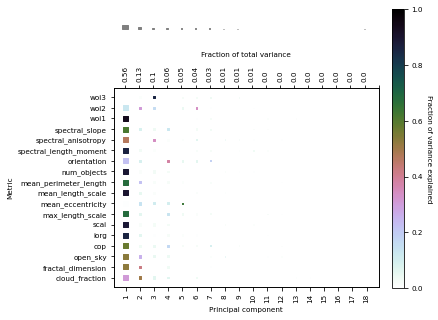

Metric: cloud_fraction Mag:  0.009022927141130774
Metric: fractal_dimension Mag:  0.01566185611499351
Metric: open_sky Mag:  0.01581923699259329
Metric: cop Mag:  0.00038892457678779544
Metric: iorg Mag:  0.013359790924019711
Metric: scai Mag:  0.123726086169509
Metric: max_length_scale Mag:  13.660795815167777
Metric: mean_eccentricity Mag:  0.004179927999670953
Metric: mean_length_scale Mag:  0.5506109421374239
Metric: mean_perimeter_length Mag:  1.6995180139409964
Metric: num_objects Mag:  101.60053797313121
Metric: orientation Mag:  0.01965101959210126
Metric: spectral_length_moment Mag:  2.6467190863709233
Metric: spectral_anisotropy Mag:  0.006945787442541171
Metric: spectral_slope Mag:  0.04957481822602364
Metric: woi1 Mag:  0.028493830407728127
Metric: woi2 Mag:  2.030506729252588e-06
Metric: woi3 Mag:  0.0058148841839894515
Metric: cloud_fraction Mag:  0.0029253065410564023
Metric: fractal_dimension Mag:  0.005447576639264892
Metric: open_sky Mag:  0.010280375729396765
Metric:

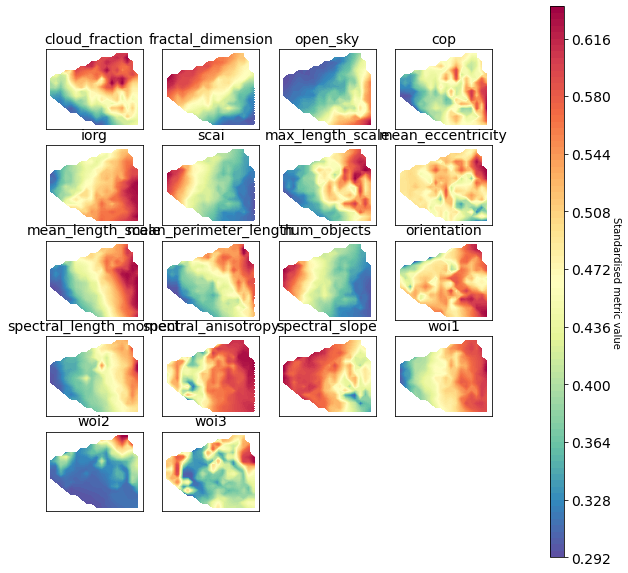

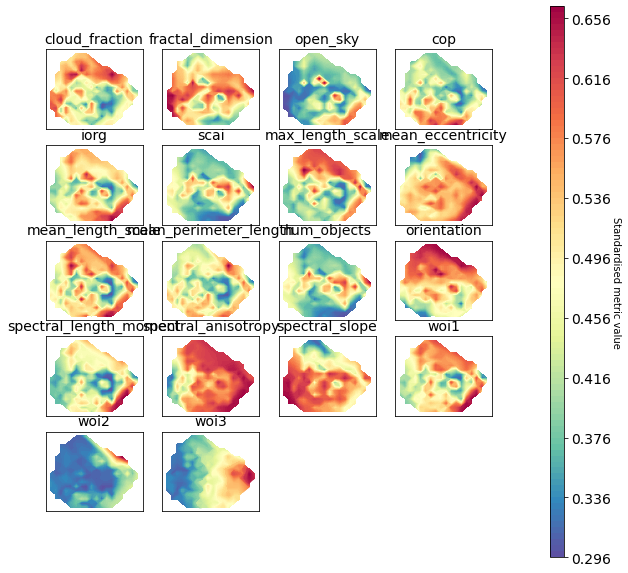

In [68]:
analysis.relateMetricPCA(pca, x_pca, metrics, metrics, './Figures')

axs = utils.plotMetricSurf(x_pca[:,0:2], df_metrics_pp, metrics, metrics,thr=0)
plt.savefig('Figures/interpolation-pc12.pdf',dpi=300,bbox_inches='tight')

axs = utils.plotMetricSurf(x_pca[:,2:4], df_metrics_pp, metrics, metrics,thr=0)
plt.savefig('Figures/interpolation-pc34.pdf',dpi=300,bbox_inches='tight')

At a glance, these are remarkably similar to the correlations I got with MODIS images, which is encouraging. Now the question is: How do they relate to the identified classes?